C:\Users\Arushi Sharma\AppData\Local\Temp\ipykernel_18680\2996135711.py:86: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arushi Sharma\AppData\Local\Temp\ipykernel_18680\2996135711.py:89: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path)
C:\Users\Arushi Sharma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


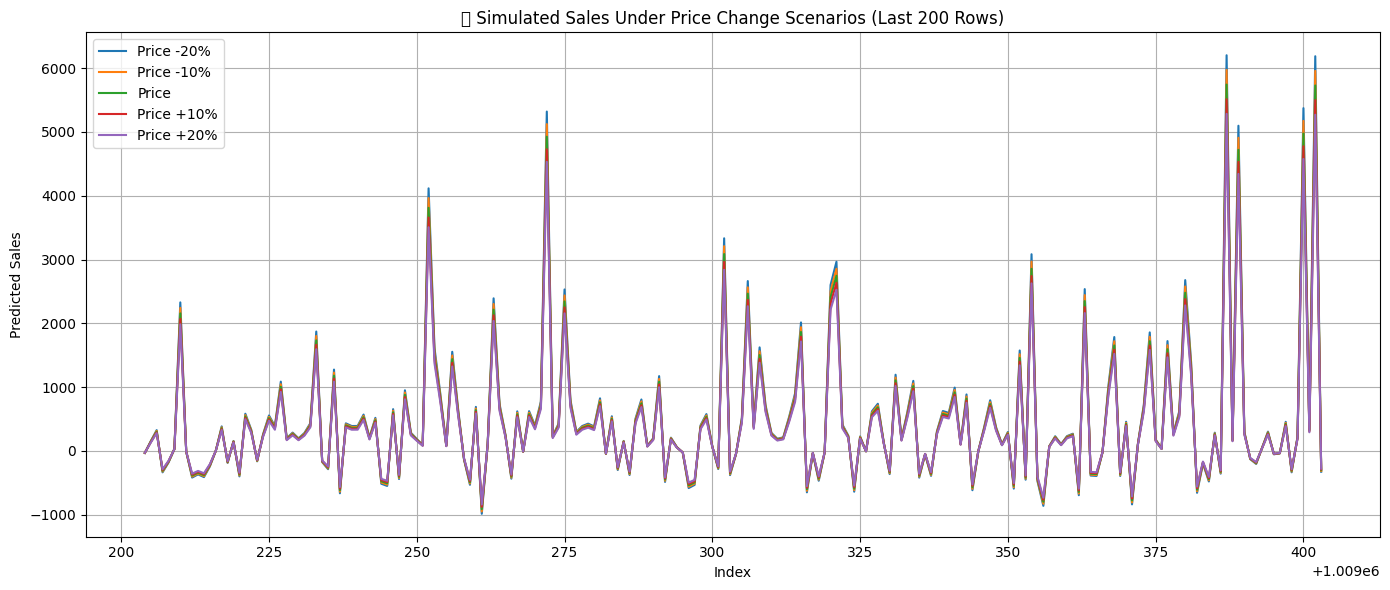

✅ Simulation plot saved to: C:\Users\Arushi Sharma\Documents\retail_demand_forecasting\outputs\plots\price_simulation_comparison.png


In [4]:
# 🧪 02c_price_simulation.ipynb
# Post-training price simulation with NO feature mismatch

from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# -----------------------------
# ✅ Step 1: Load Everything
# -----------------------------
PROJECT_ROOT = Path(r"C:\Users\Arushi Sharma\Documents\retail_demand_forecasting")
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "models"
PLOT_DIR = PROJECT_ROOT / "outputs" / "plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA_DIR / "features_rossmann.parquet")
model = joblib.load(MODEL_DIR / "xgb_best_model.pkl")
expected_features = joblib.load(MODEL_DIR / "xgb_best_model_features.pkl")

# -----------------------------
# ✅ Step 2: Preprocess like training
# -----------------------------
df = df.dropna(subset=["Sales", "SalesLag1", "SalesLag7", "SalesMA7"])
df["Store"] = df["Store"].astype("int32")
df["DayOfWeek"] = df["DayOfWeek"].astype("int8")
df["Promo"] = df["Promo"].astype("int8")
df["SchoolHoliday"] = df["SchoolHoliday"].astype("int8")
df["StateHoliday"] = df["StateHoliday"].astype("category").cat.codes
df["SalesLag1"] = df["SalesLag1"].astype("float32")
df["SalesLag7"] = df["SalesLag7"].astype("float32")
df["SalesMA7"] = df["SalesMA7"].astype("float32")
df["Year"] = df["Year"].astype("int16")
df["Month"] = df["Month"].astype("int8")
df["WeekOfYear"] = df["WeekOfYear"].astype("int8")
df["IsWeekend"] = df["IsWeekend"].astype("int8")

# Final input to model (matching training!)
X_test = df[expected_features].copy()

# -----------------------------
# ✅ Step 3: Predict Base Sales
# -----------------------------
y_base_pred = model.predict(X_test)

# -----------------------------
# 🧪 Step 4: Simulate Price Scenarios
# -----------------------------
# Define synthetic price variants (just for simulation, not in model input)
variants = {
    "Price -20%": 0.8,
    "Price -10%": 0.9,
    "Price": 1.0,
    "Price +10%": 1.1,
    "Price +20%": 1.2,
}

# Assume sales elasticity: 40% change in sales for 100% price change
elasticity = -0.4  # Negative: price up = sales down

simulation_results = {}

for label, price_factor in variants.items():
    multiplier = 1 + elasticity * (price_factor - 1.0)
    simulated_sales = y_base_pred * multiplier
    simulation_results[label] = simulated_sales

# -----------------------------
# ✅ Step 5: Visualize
# -----------------------------
rows = 200
plot_df = pd.DataFrame({k: v[-rows:] for k, v in simulation_results.items()})
plot_df.index = df.tail(rows).index

plt.figure(figsize=(14, 6))
for label in plot_df.columns:
    plt.plot(plot_df.index, plot_df[label], label=label)

plt.title("🛍️ Simulated Sales Under Price Change Scenarios (Last 200 Rows)")
plt.xlabel("Index")
plt.ylabel("Predicted Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = PLOT_DIR / "price_simulation_comparison.png"
plt.savefig(plot_path)
plt.show()

print(f"✅ Simulation plot saved to: {plot_path}")


In [7]:
# -----------------------------
# ✅ Step 6: Export Simulation Results to CSV
# -----------------------------

# Create DataFrame from simulation dictionary
simulation_df = pd.DataFrame(simulation_results)

# Add index as datetime or date reference if needed
simulation_df.index = df.tail(len(simulation_df)).reset_index(drop=True).index

# Optionally add original predicted sales (baseline)
baseline = model.predict(X_test[expected_features])
simulation_df["Baseline"] = baseline

# Optionally add actual sales (if available)
simulation_df["ActualSales"] = df.tail(len(simulation_df))["Sales"].values

# Save to CSV
csv_path = PROJECT_ROOT / "outputs" / "price_simulation_predictions.csv"
simulation_df.to_csv(csv_path, index=False)

print(f"✅ Simulation results saved to: {csv_path}")


✅ Simulation results saved to: C:\Users\Arushi Sharma\Documents\retail_demand_forecasting\outputs\price_simulation_predictions.csv
